# Figure Warden - Modularity Paper

We present two images, sampled without replacement from a set of 4, each image is encoded as a one-hot vector.

There are 5 timepoints, see first image, delay, see second image, delay, report both images.

In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import vmap, value_and_grad, grad, jit, random
import jax.nn as jnn
from mpl_toolkits.mplot3d import Axes3D
import math
import optax
import scipy

Text(0.5, 1.0, 'Outputs')

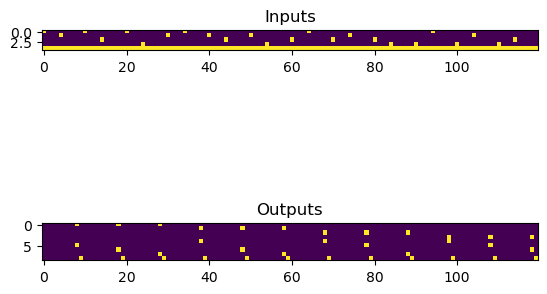

In [202]:
repeat = 0
delay_len = 3
reward = 1

num_trials = 4*(4-(1-repeat))
task_len = 3  + 2*delay_len + reward
D = task_len*num_trials # Total number of conditions

inputs = np.zeros([4, D])
outputs = np.zeros([9, D])

counter = 0
use = 0
for target_1 in range(4):
    for target_2 in range(4):
        use = 0
        if repeat == 0 and target_2 != target_1:
            use = 1
        elif repeat == 1:
            use = 1

        if use:
            inputs[target_1,counter] = 1
            inputs[target_2,counter + 1 + delay_len] = 1
    
            outputs[target_1,counter+ 2 + 2*delay_len] = 1
            outputs[target_2+4,counter+ 2 + 2*delay_len] = 1
            outputs[-1,counter + 3 + 2*delay_len] = 1
            counter += task_len
            
# Now stack a bias on the inputs
inputs = np.vstack([inputs, np.ones([1, inputs.shape[1]])])

plt.subplot(2, 1, 1)
plt.title('Inputs')
plt.imshow(inputs)

plt.subplot(2,1,2)
plt.imshow(outputs)
plt.title('Outputs')

In [203]:
task_len

10

In [204]:
def initialise_weights(N, random_seed, init_scale = 0.01):
    W1 = jnp.zeros([N, N+1])
    W2 = jnp.zeros([N, N+1])

    key = random.PRNGKey(random_seed)
    W = random.normal(key, (N,N))*init_scale
    W, S, V = jnp.linalg.svd(W)
    W1 = W1.at[:,:N].set(W)

    key, subkey = random.split(key)
    W = random.normal(key, (N,N))*init_scale
    W, S, V = jnp.linalg.svd(W)
    W2 = W2.at[:,:N].set(W)

    I = random.normal(key, (N, 5))*init_scale
    W1 = W1.at[:,-1].set(random.normal(key, (N,))*init_scale)
    W2 = W2.at[:,-1].set(random.normal(key, (N,))*init_scale)
    R = random.normal(key, (8+reward,N+1))*init_scale
    params = {'W1':W1, 'W2':W2, 'I':I, 'R':R}
    
    return params

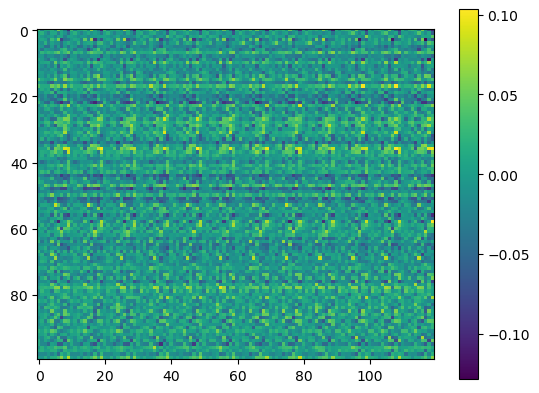

In [207]:
N = 100
random_seed = 4315342643164
params = initialise_weights(N, random_seed)

@jit
def generate_rep(params, inputs):
    g = jnp.zeros([N+1, D])
    g = g.at[-1:,:].set(np.ones([1,g.shape[1]]))
    g = g.at[:-1,::task_len].set(params["I"]@inputs[:,::task_len])
    for t in range(1,1+delay_len):
        g = g.at[:-1,t::task_len].set(params["W1"]@g[:,t-1::task_len])
    g = g.at[:-1,1+delay_len::task_len].set(params["W2"]@g[:,delay_len::task_len]+ params["I"]@inputs[:,1+delay_len::task_len])
    for t in range(2+delay_len, task_len):
        g = g.at[:-1,t::task_len].set(params["W1"]@g[:,t-1::task_len])
    return g

plt.imshow(generate_rep(params, inputs)[:-1,:])
plt.colorbar()

In [222]:
@jit
def loss_pos(g):
    g_neg = (g[:-1,:] - jnp.abs(g[:-1,:]))/2
    L_pos = -jnp.sum(g_neg)
    return L_pos

@jit
def loss_act(g):
    return jnp.sum(jnp.power(g[:-1,:], 2))

@jit
def loss_weight(W):
    return jnp.sum(jnp.power(W[:,:-1], 2))

@jit
def loss_weight_I(I):
    return jnp.sum(jnp.power(I[:,:-1],2))


@jit
def generate_R(g, outputs):
    mat0 = jnp.matmul(g, g.T)
    mat1 = jnp.matmul(g, outputs.T)
    mat2 = jnp.matmul(jnp.linalg.inv(mat0 + 0.0001*jnp.eye(N+1)), mat1)
    return mat2

@jit
def loss_R(R):
    return jnp.linalg.norm(generate_R(g, targets))**2

@jit
def loss_fit(g, R, outputs):
    preds = R@g
    return jnp.linalg.norm(outputs - preds)

mu_fit = 1000
mu_G = 1
mu_W = 1
mu_R = 1
mu_pos = 1000
fit_thresh = 0.01

@jit
def loss(params, inputs, outputs):
    g = generate_rep(params, inputs)
    
    return mu_fit*jnn.relu(loss_fit(g, params['R'], outputs)-fit_thresh) + mu_G*loss_act(g) + mu_W*(loss_weight(params["W1"]) + loss_weight(params['W2'])) + mu_R*(loss_weight_I(params["I"]) + loss_weight(params['R'])) + mu_pos*loss_pos(g)

@jit
def update(params, inputs, outputs, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, inputs, outputs)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, value

random_seed = 43434242
learning_rate = 1e-5

re_init = 0
if re_init:
    optimizer = optax.adam(learning_rate)
    # Obtain the `opt_state` that contains statistics for the optimizer.
    params = initialise_weights(N, random_seed)
    opt_state = optimizer.init(params)
print(loss(params, inputs, outputs))
min_loss = np.infty

112.493935


In [251]:
T = 10000000
print_iter = 10000

for t in range(T):
    params, opt_state, loss = update(params, inputs, outputs, opt_state)


    if t % print_iter == 0:
        g = generate_rep(params, inputs)

        L_f = loss_fit(g, params['R'], outputs)
        L_a = loss_act(g)
        L_w1 = loss_weight(params["W1"])
        L_w2 = loss_weight(params["W2"])
        L_R = loss_act(params['R'])
        L_p = loss_pos(g)
        L_I = loss_weight(params["I"])    
        print(f"Step {t}, Loss: {loss:.5f}, Fit: {L_f:.5f}, Act: {L_a:.5f}, Wei: {L_w1:.5f} {L_w2:.5f}, R: {L_R:.5f}, Pos: {L_p:.5f}, I: {L_I:.5f}")
        #print(f"Step {t}, Loss: {loss:.5f}")#, Fit: {L_f:.5f}, Act: {L_a:.5f}, Wei: {L_w:.5f}, R: {L_R:.5f}, Pos: {L_p:.5f}, PI: {L_PI:.5f}")

        min_this_step = 0

    if loss < min_loss:
        params_best = params
        min_loss = loss
        if min_this_step == 0:
            print(f'New min! {loss}')
            min_this_step = 1

Step 0, Loss: 97.99839, Fit: 0.00442, Act: 26.74316, Wei: 41.14099 2.12629, R: 21.33304, Pos: -0.00000, I: 0.74090
Step 10000, Loss: 96.15243, Fit: 0.01550, Act: 26.72801, Wei: 41.14285 2.13878, R: 21.32624, Pos: 0.00000, I: 0.74214
Step 20000, Loss: 98.68896, Fit: 0.01097, Act: 26.73290, Wei: 41.15659 2.15062, R: 21.33050, Pos: -0.00000, I: 0.74159
Step 30000, Loss: 96.09991, Fit: 0.01636, Act: 26.71646, Wei: 41.13825 2.12649, R: 21.31965, Pos: -0.00000, I: 0.74168
Step 40000, Loss: 98.34288, Fit: 0.00456, Act: 26.74826, Wei: 41.13505 2.12552, R: 21.33691, Pos: -0.00000, I: 0.73994
Step 50000, Loss: 96.13824, Fit: 0.01370, Act: 26.71499, Wei: 41.14825 2.13386, R: 21.32944, Pos: -0.00000, I: 0.74030
Step 60000, Loss: 96.14970, Fit: 0.01120, Act: 26.71120, Wei: 41.15321 2.14204, R: 21.32092, Pos: -0.00000, I: 0.74554
Step 70000, Loss: 97.33057, Fit: 0.00406, Act: 26.72784, Wei: 41.12525 2.12302, R: 21.33422, Pos: -0.00000, I: 0.73847
Step 80000, Loss: 96.19263, Fit: 0.00541, Act: 26.747

KeyboardInterrupt: 

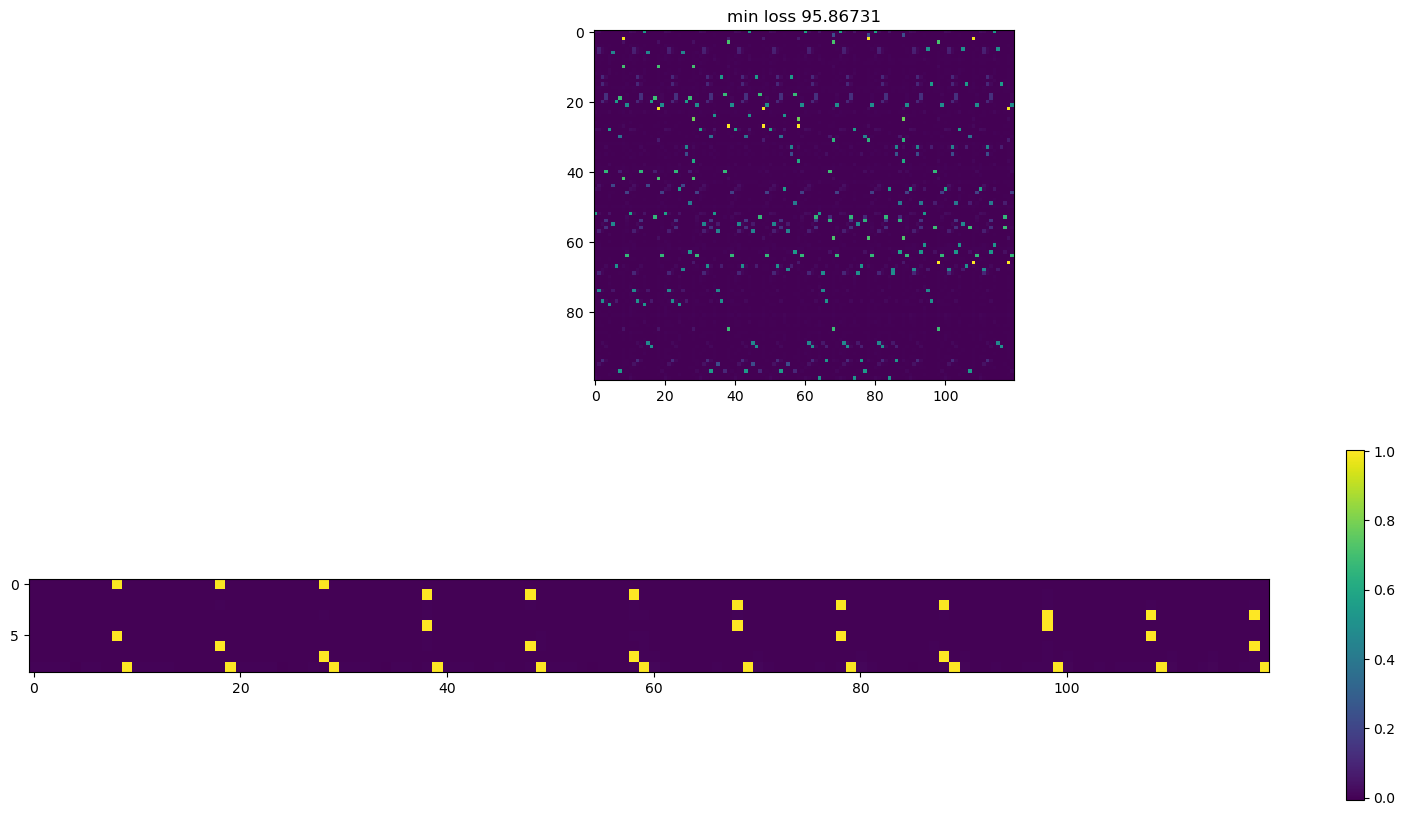

In [252]:
g = generate_rep(params_best, inputs)
plt.figure(figsize = (20, 10))
plt.subplot(2, 1, 1)
plt.imshow(g[:-1,:])
plt.title(f'min loss {min_loss:.5f}')

R = generate_R(g, outputs)
preds = R.T@g

plt.subplot(2,1,2)
plt.imshow(preds)
plt.colorbar()

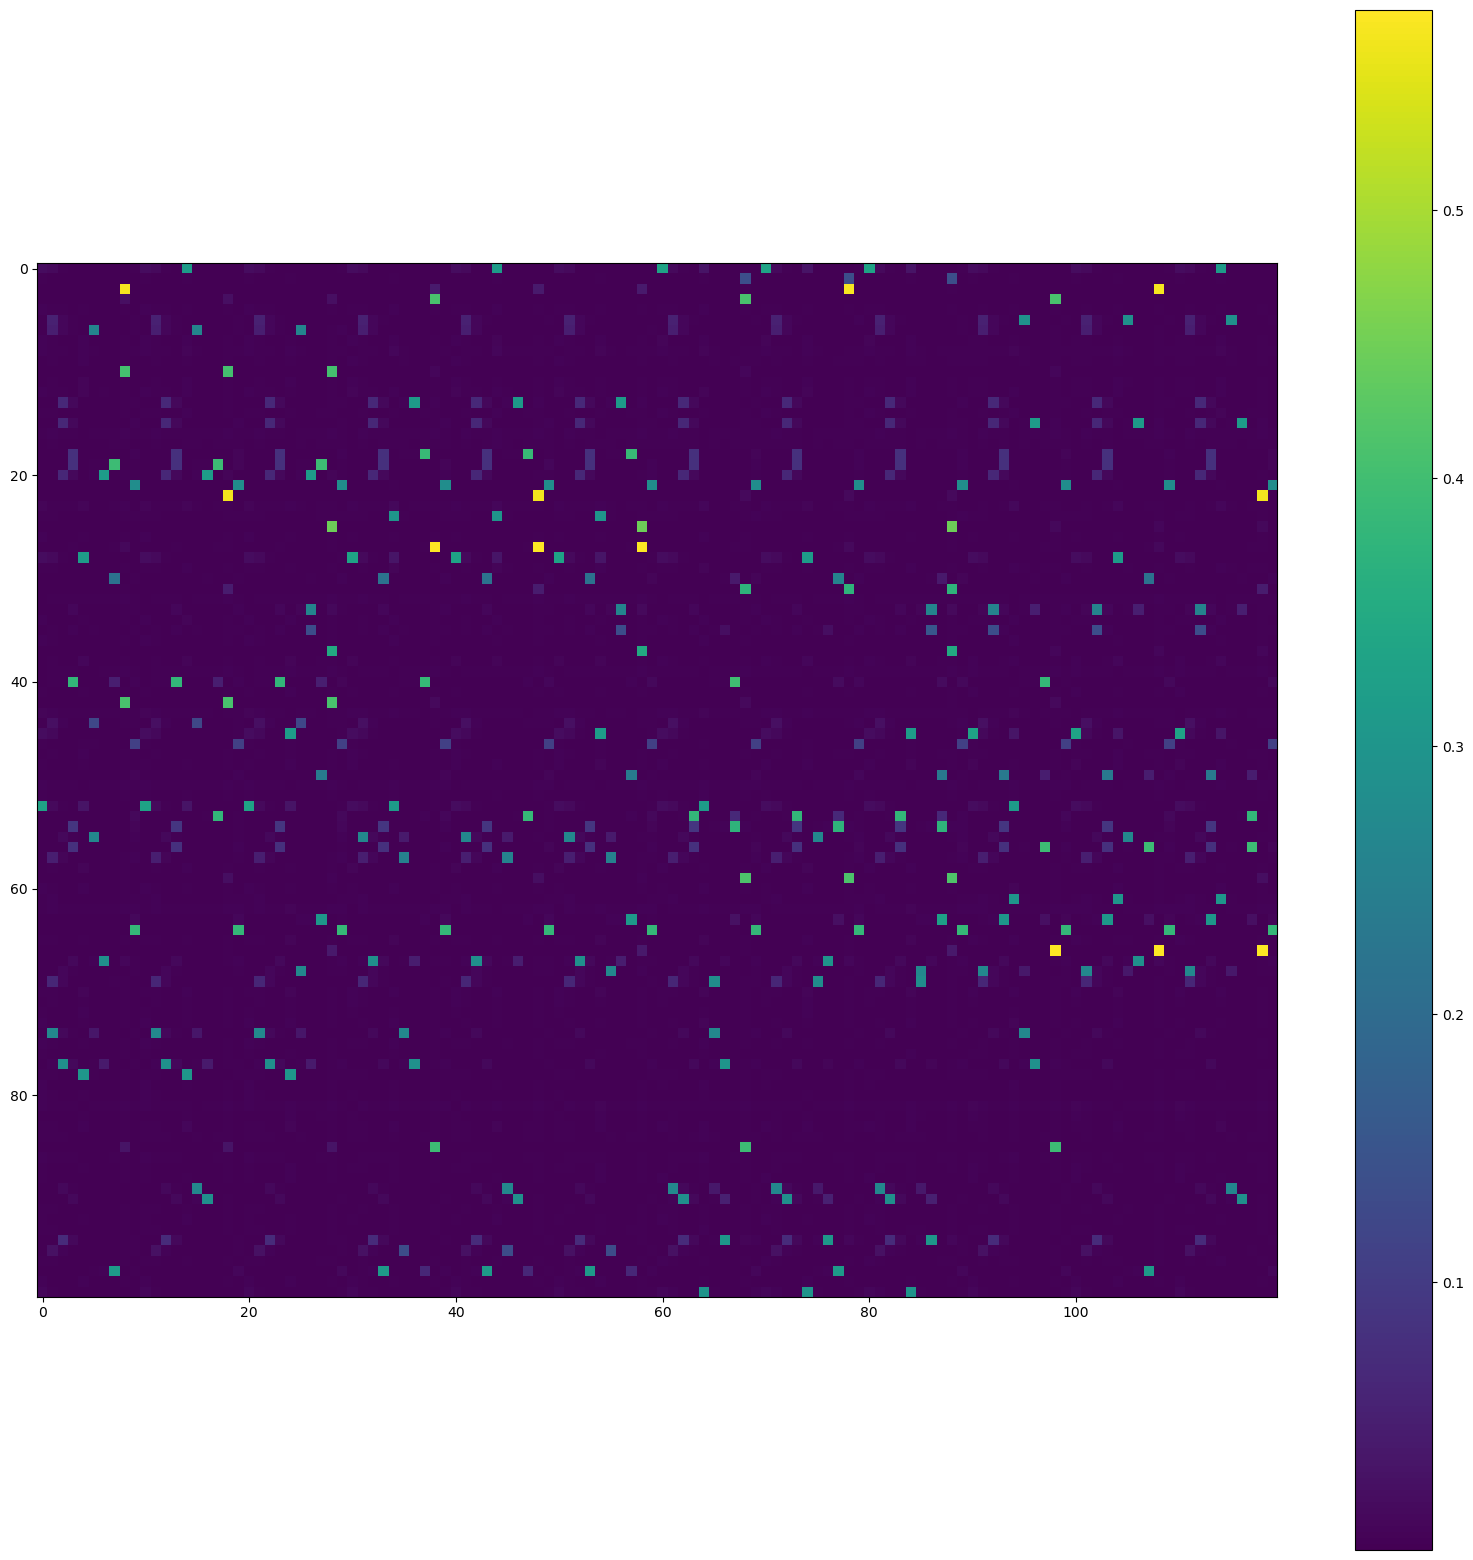

In [253]:
plt.figure(figsize = (20, 20))
plt.imshow(g[:-1,:])
plt.colorbar()

In [254]:
np.save('./data/test_warden.npy', params_best)


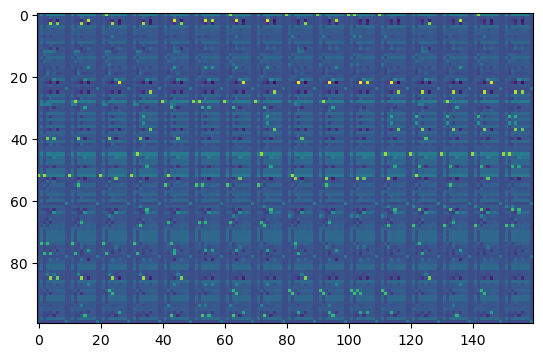

In [249]:
D_uncorr = 16*task_len
inputs_uncorr = np.zeros([4, D_uncorr])
outputs_uncorr = np.zeros([8, D_uncorr])

counter = 0
for target_1 in range(4):
    for target_2 in range(4):
            inputs_uncorr[target_1,counter] = 1
            inputs_uncorr[target_2,counter + 2] = 1

            outputs_uncorr[target_1,counter+4] = 1
            outputs_uncorr[target_2+4,counter+4] = 1
            counter += task_len

inputs_uncorr = np.vstack([inputs_uncorr, np.ones([1, inputs_uncorr.shape[1]])])

@jit
def generate_rep_uncorr(params, inputs):
    g = jnp.zeros([N+1, D_uncorr])
    g = g.at[-1:,:].set(np.ones([1,g.shape[1]]))
    g = g.at[:-1,::task_len].set(params["I"]@inputs[:,::task_len])
    for t in range(1,task_len-1):
        g = g.at[:-1,t::task_len].set(params["I"]@inputs[:,t::task_len] + params["W1"]@g[:,t-1::task_len])
    g = g.at[:-1,task_len-1::task_len].set(params["W2"]@g[:,task_len-2::task_len])
    return g


g_uncorr = generate_rep_uncorr(params_best, inputs_uncorr)[:-1,:]

plt.imshow(g_uncorr)

In [296]:
# Now we should find neurons that are selective to a stimulus at a particular delay?
g_avg = np.zeros([N, task_len, 2, 4])

for order in range(2):
    for stim in range(4):
        for t in range(task_len):
            trial_starts = np.where(inputs_uncorr[stim,order*2::task_len] == 1)[0]*task_len
            g_avg[:,t,order,stim] = np.mean(g_uncorr[:, trial_starts+t], axis = 1)

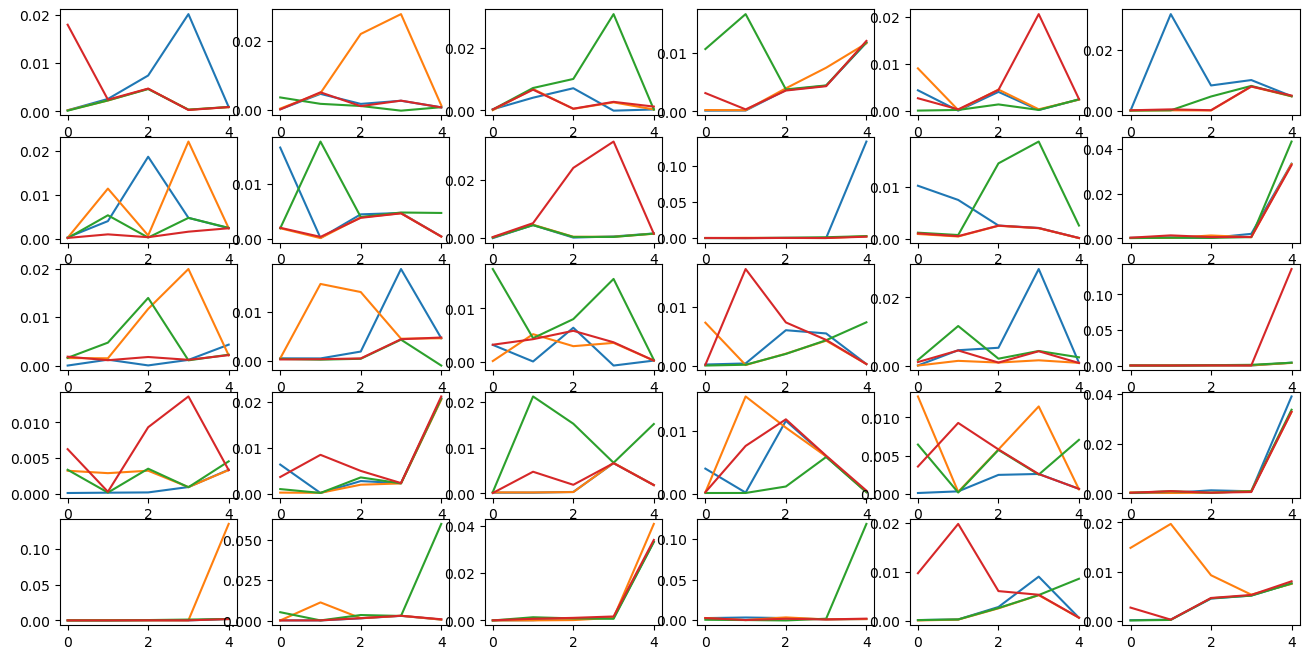

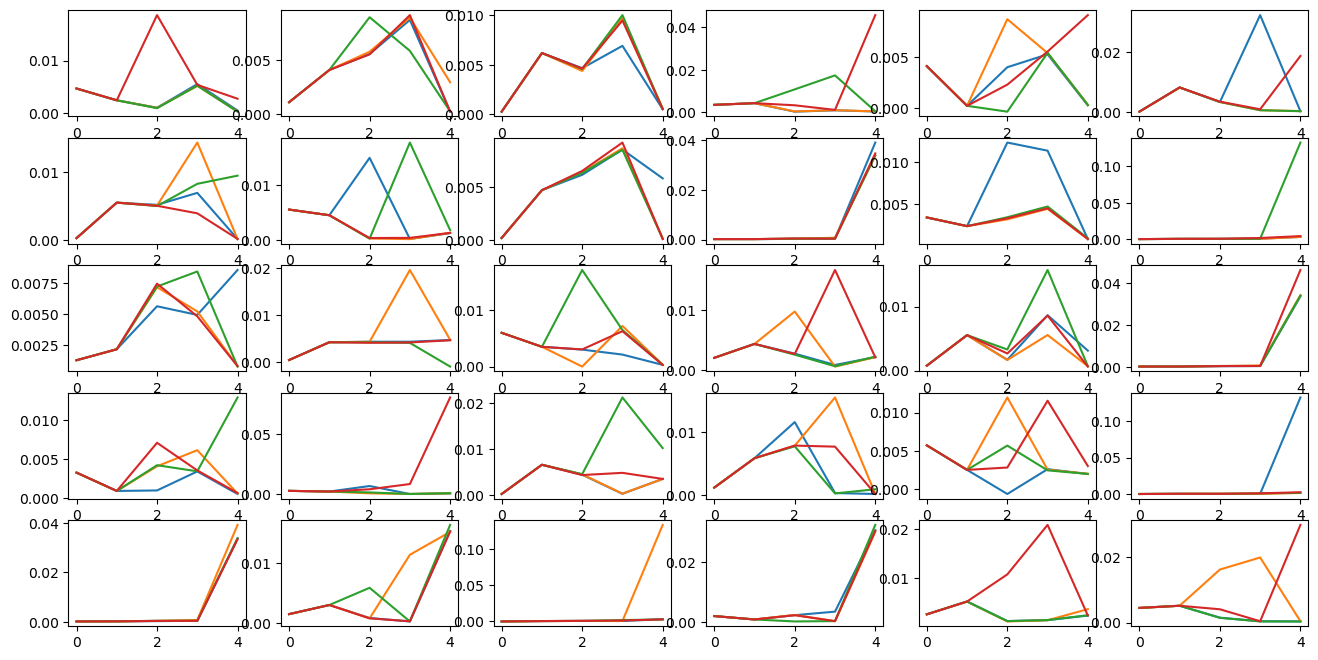

In [297]:
plt.figure(figsize = (16, 8))
for neuron in range(N):
    plt.subplot(5, 6, 1+neuron)
    plt.plot(g_avg[neuron,:,0,:])

plt.figure(figsize = (16,  8))
for neuron in range(N):
    plt.subplot(5, 6, 1+neuron)
    plt.plot(g_avg[neuron,:,1,:])

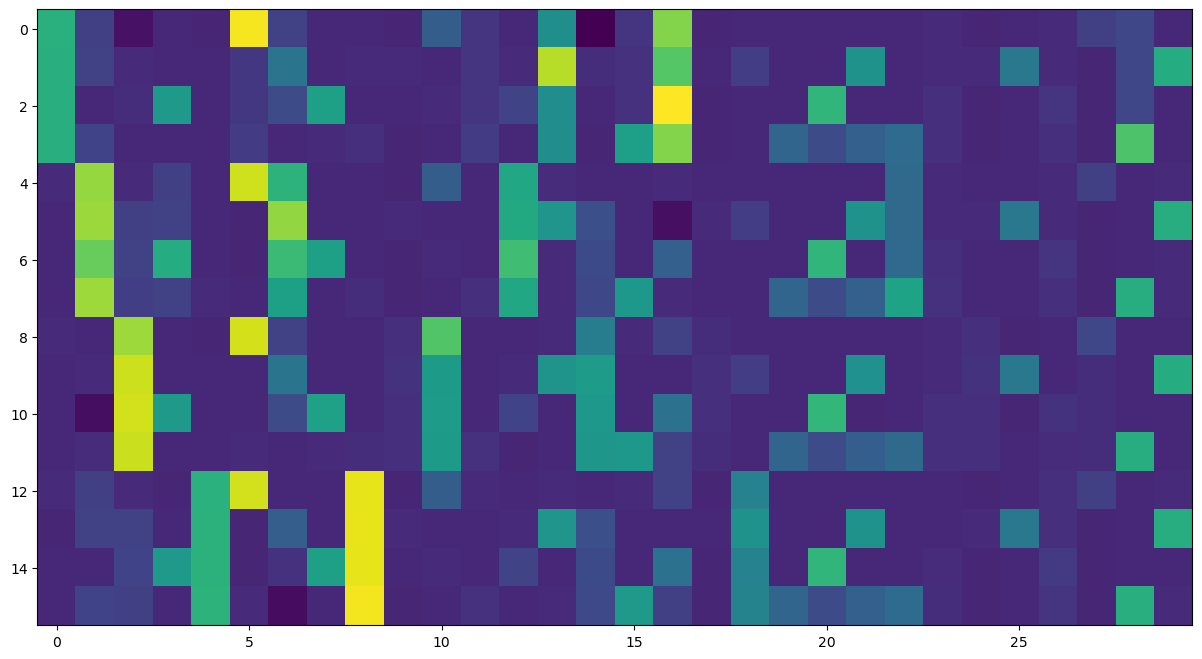

In [298]:
plt.figure(figsize = (16, 8))
plt.imshow(g_uncorr[:,3::task_len].T)


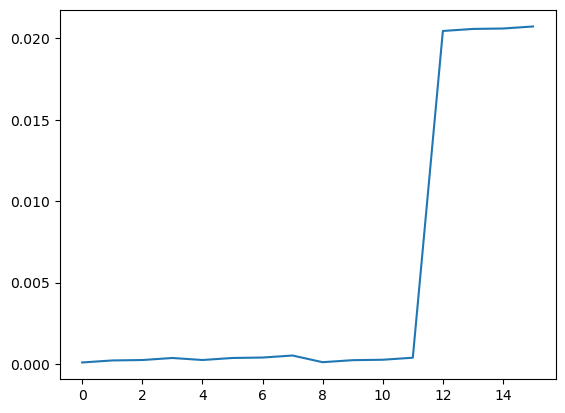

In [299]:
plt.plot(g_uncorr[4,3::task_len])